In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn jupyterlab

  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl.metadata (15 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.3.0-cp39-cp39-win_amd64.whl.metadata (9.2 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached httpx-0.28.1

In [3]:
# Step 1: Import libraries and setup paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Paths
RAW_PATH = "../data/intern_data_ikarus.csv"
CLEAN_PATH = "../data/preprocessed_products.csv"


In [4]:
# Step 2: Load dataset
df = pd.read_csv(RAW_PATH)
print("Shape:", df.shape)
df.head(3)


Shape: (312, 12)


,title,brand,description,price,categories,images,manufacturer,package_dimensions,country_of_origin,material,color,uniq_id
0,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...",GOYMFK,"multiple shoes, coats, hats, and other items E...",$24.99,"['Home & Kitchen', 'Storage & Organization', '...",['https://m.media-amazon.com/images/I/416WaLx1...,GOYMFK,"2.36""D x 7.87""W x 21.6""H",China,Metal,White,02593e81-5c09-5069-8516-b0b29f439ded
1,"subrtex Leather ding Room, Dining Chairs Set o...",subrtex,subrtex Dining chairs Set of 2,NaN,"['Home & Kitchen', 'Furniture', 'Dining Room F...",['https://m.media-amazon.com/images/I/31SejUEW...,Subrtex Houseware INC,"18.5""D x 16""W x 35""H",NaN,Sponge,Black,5938d217-b8c5-5d3e-b1cf-e28e340f292e
2,Plant Repotting Mat MUYETOL Waterproof Transpl...,MUYETOL,NaN,$5.98,"['Patio, Lawn & Garden', 'Outdoor Décor', 'Doo...",['https://m.media-amazon.com/images/I/41RgefVq...,MUYETOL,"26.8""L x 26.8""W",NaN,Polyethylene,Green,b2ede786-3f51-5a45-9a5b-bcf856958cd8


In [5]:
# Step 3: Quick overview
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop duplicate uniq_ids (if any)
df = df.drop_duplicates(subset='uniq_id')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               312 non-null    object
 1   brand               312 non-null    object
 2   description         159 non-null    object
 3   price               215 non-null    object
 4   categories          312 non-null    object
 5   images              312 non-null    object
 6   manufacturer        205 non-null    object
 7   package_dimensions  306 non-null    object
 8   country_of_origin   125 non-null    object
 9   material            218 non-null    object
 10  color               265 non-null    object
 11  uniq_id             312 non-null    object
dtypes: object(12)
memory usage: 29.4+ KB

Missing values per column:
title                   0
brand                   0
description           153
price                  97
categories              0
images                 

In [6]:
# Step 4: Clean the price column

def clean_price(p):
    if pd.isna(p):
        return np.nan
    p = str(p).replace('$','').replace(',','').strip()
    try:
        return float(p)
    except:
        return np.nan

df['price'] = df['price'].apply(clean_price)
print("Unique price values:", df['price'].nunique())
print("Price range:", df['price'].min(), "to", df['price'].max())

# Fill missing prices with median
df['price'] = df['price'].fillna(df['price'].median())


Unique price values: 135
Price range: 0.6 to 349.0


In [7]:
# Step 5: Combine textual fields for embeddings
text_cols = ['title', 'brand', 'description', 'categories', 'material', 'color']
for col in text_cols:
    df[col] = df[col].fillna('').astype(str).str.strip()

df['text_blob'] = (
    df['title'] + " " +
    df['brand'] + " " +
    df['description'] + " " +
    df['categories'] + " " +
    df['material'] + " " +
    df['color']
).str.lower()

df['text_blob'] = df['text_blob'].str.replace(r'\s+', ' ', regex=True)
df[['uniq_id','text_blob']].head(3)


,uniq_id,text_blob
0,02593e81-5c09-5069-8516-b0b29f439ded,"goymfk 1pc free standing shoe rack, multi-laye..."
1,5938d217-b8c5-5d3e-b1cf-e28e340f292e,"subrtex leather ding room, dining chairs set o..."
2,b2ede786-3f51-5a45-9a5b-bcf856958cd8,plant repotting mat muyetol waterproof transpl...


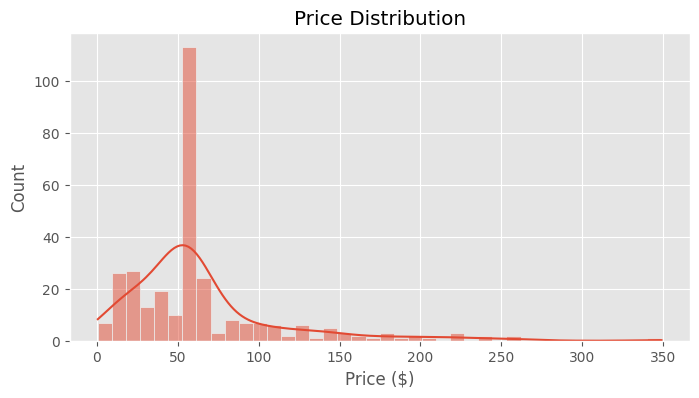

In [8]:
# Step 6: Plot price distribution
plt.figure(figsize=(8,4))
sns.histplot(df['price'], bins=40, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()


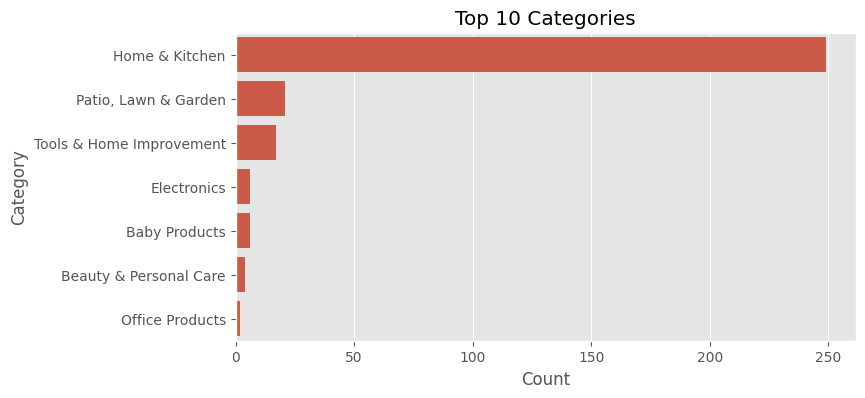

In [9]:
# Step 7: Plot most frequent categories
def get_primary_category(cat):
    try:
        if isinstance(cat, str):
            # categories might be list-like strings: '["Furniture > Chairs"]'
            parsed = ast.literal_eval(cat) if cat.startswith('[') else cat
            if isinstance(parsed, list): return parsed[0]
            return parsed.split(">")[0].strip()
        return np.nan
    except Exception:
        return np.nan

df['primary_category'] = df['categories'].apply(get_primary_category)
topcats = df['primary_category'].value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(y=topcats.index, x=topcats.values)
plt.title("Top 10 Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


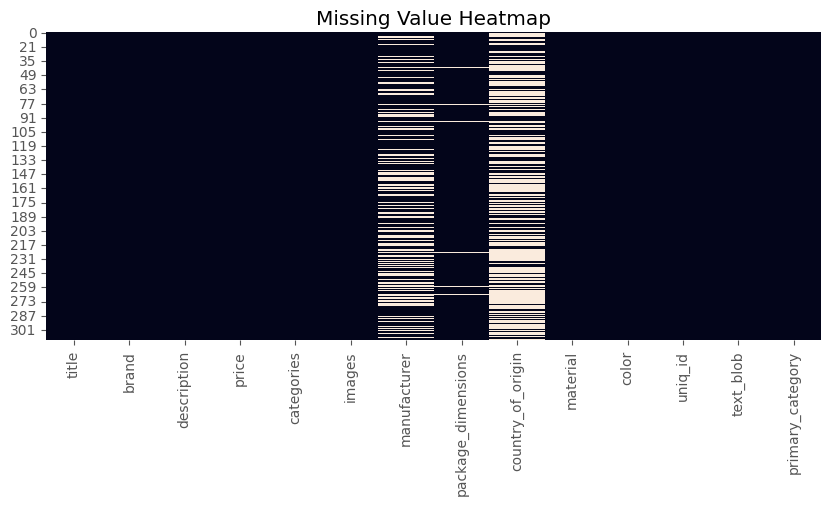

In [10]:
# Step 8: Visualize missing data
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()


In [11]:
# Step 9: Save cleaned file
os.makedirs("../data", exist_ok=True)
df.to_csv(CLEAN_PATH, index=False)
print(f"✅ Cleaned dataset saved to: {CLEAN_PATH}")
print("Final shape:", df.shape)


✅ Cleaned dataset saved to: ../data/preprocessed_products.csv
Final shape: (305, 14)


In [12]:
# Step 10: Sample verification
df.sample(5)[['uniq_id','title','price','primary_category','text_blob']].head()


,uniq_id,title,price,primary_category,text_blob
53,9762324d-bb95-5daa-a613-7c5f77eb01f6,Franklin Sports NFL Storage Ottoman + Containe...,39.99,Home & Kitchen,franklin sports nfl storage ottoman + containe...
48,e03d22da-0321-5be0-8787-7eedeb2d104a,1 Pack Adjustable Height Center Support Leg fo...,13.90,Home & Kitchen,1 pack adjustable height center support leg fo...
273,b0dfa07f-a9b7-58a0-8f29-83b74b5f9e42,Hosley Wooden Frame Mirror 20 Inch High. Ideal...,24.99,Home & Kitchen,hosley wooden frame mirror 20 inch high. ideal...
132,85e6db14-ec39-5dba-b57f-116f9e5b1224,"Lipper International Wooden Storage Crate, whi...",50.00,Home & Kitchen,"lipper international wooden storage crate, whi..."
231,e1988a1e-6fc2-5fbd-ae77-f7a836e2c2d8,It's_Organized Gaming Desk 55 inch PC Computer...,139.99,Home & Kitchen,it's_organized gaming desk 55 inch pc computer...
